[Тут](https://colab.research.google.com/drive/1EpJkZLzM0v4c7A3O9XWtXds1_7xAreZx) весь оставшийся мусор по  подготовке датасетов

Пока: 


*   Каждые 10к датасета дают +0.02 accuracy (20к - 0.81; 50к - 0.86)
*   То, что выше - это получается на первых 2-3 эпохах, дальше модель переобучается. 
*   Если убрать стопслова из датасета на 50к записей, то результаты хуже (0.8 acc)




In [0]:
# TODO 
# Grover dataset (46gb)
# Модель с нейросеток посмотреть, мб перенести

In [0]:
!pip install transformers

In [133]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy.symbols import ORTH
import re
import json
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec, KeyedVectors

import torch
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import Vectors

from transformers import GPT2Tokenizer, GPT2LMHeadModel

LENGTH = 10000
SEED = 42
np.random.seed(SEED)

import nltk
from nltk import tokenize
nltk.download('punkt')

spacy_en = spacy.load('en')
spacy_en.tokenizer.add_special_case("don't", [{ORTH: "do"}, {ORTH: "not"}])
spacy_en.tokenizer.add_special_case("didn't", [{ORTH: "did"}, {ORTH: "not"}]) #adding special case so that tokenizer("""don't""") != 'do'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def clean_data(text):
    text = re.sub(r'\<[^>]*\>', '', text)
    text = re.sub(r'\<[^>]*\>', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    return text

In [0]:
def sent_first(text): # to gpt2
    return tokenize.sent_tokenize(text)[0]

def sent_splitter(text): # to classification model
    return ' '.join(tokenize.sent_tokenize(text)[:2])

def tokenizer(text):
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [0]:
def open_file(file):
    with open(file, 'r', encoding='utf-8') as f:
        fake = [line for line in f.readlines()]
    return fake

# Process Original Dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

idd = '1h_kUrWbKvZR0iRms8zKMUJO5zq9wbIXW'
downloaded_ = drive.CreateFile({'id':idd}) 
downloaded_.GetContentFile('train.jsonl')

In [0]:
def initial(file, start_idx=0):
    
    with open(file, 'r') as json_file:
        json_list = list(json_file)[start_idx:start_idx+LENGTH]
    
    data = []
    for json_str in json_list:
        result = json.loads(json_str)
        data.append(result['text'])

    df = pd.DataFrame()
    df['text'] = data
    df['label'] = ['real'] * len(data)
    df['text'] = df['text'].apply(clean_data)
    
    return df

In [0]:
def process_df(df):

    text_gpt2 = list(df['text'].apply(sent_first))[:LENGTH]
    df.text  = df['text'].apply(sent_splitter)

    return text_gpt2, df 

In [0]:
df = initial('train.jsonl', start_idx=40000)
text_gpt2, df = process_df(df)

In [77]:
df.head()

,text,label
0,The first of four separate Eurostar strikes by...,real
1,Too much of America’s foreign aid funds what I...,real
2,Olympic boxer Nico Hernandez may not be answer...,real
3,Chinese diver He Zi received both a silver med...,real
4,Keshia Knight Pulliam says her estranged husba...,real


In [78]:
len(text_gpt2), text_gpt2[0]

(10000,
 'The first of four separate Eurostar strikes by staff from two unions gets under way on Friday but the impact on services is set to be limited.')

In [79]:
text_gpt2[-1], df.text.tolist()[-1]

('Hollywood has nothing on Greater Boston’s technology world when it comes to an obsession with youth.',
 'Hollywood has nothing on Greater Boston’s technology world when it comes to an obsession with youth. From Kendall Square to the Innovation District, companies trip over each other every day to recruit new, fresh-faced tech talent that can help them go public.')

# Data Generation

In [0]:
MAX_LENGTH = 25
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [0]:
def generate_sentence(text, tokenizer, model):
    generated = tokenizer.encode(text)
    initial_length = len(generated)
    context = torch.tensor([generated])
    past = None

    for i in range(MAX_LENGTH):
        output, past = model(context, past=past)
        token = torch.argmax(output[0, :])

        generated += [token.tolist()]
        context = token.unsqueeze(0)
        if (tokenizer.decode(token.tolist()) in ['!', '?', '.']) and (len(generated) - initial_length > 2):
            break
    sequence = tokenizer.decode(generated)
    return sequence

In [0]:
def make_fake(texts, fake=[], real=[], df=df, tokenizer=tokenizer, model=model):
    i = 0
    for ind, el in tqdm(enumerate(texts)):
        try:
            sent = generate_sentence(el, tokenizer=tokenizer, model=model)
            sent = re.sub(r'\n', '', sent)
            fake.append(sent)
              real.append(df.text.tolist()[ind])
        except:
            i+=1
        if i % 1000 == 0:
            print(i, 'out of', ind,' are not found in emb dict')    

    with open('fake.txt', 'w', encoding='utf-8') as f:
        for item in fake:
            f.write('{}\n'.format(item))
    with open('real.txt', 'w', encoding='utf-8') as f:
        for item in real:
            f.write('{}\n'.format(item))
    return fake, real

In [84]:
fake, real = make_fake(text_gpt2, fake=fake, real=real)

1it [00:01,  1.61s/it]

0 out of 0  are not found in emb dict


2it [00:03,  1.57s/it]

0 out of 1  are not found in emb dict


3it [00:04,  1.55s/it]

0 out of 2  are not found in emb dict


4it [00:06,  1.57s/it]

0 out of 3  are not found in emb dict


2153it [28:05,  1.33it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1730 > 1024). Running this sequence through the model will result in indexing errors
2181it [28:31,  1.12it/s]

1000 out of 2180  are not found in emb dict


2182it [28:31,  1.28it/s]

1000 out of 2181  are not found in emb dict


2183it [28:32,  1.09it/s]

1000 out of 2182  are not found in emb dict


4397it [58:20,  1.64it/s]

2000 out of 4396  are not found in emb dict


6503it [1:25:25,  2.24it/s]

3000 out of 6502  are not found in emb dict


8693it [1:53:58,  1.09it/s]

4000 out of 8692  are not found in emb dict


8694it [1:53:59,  1.21it/s]

4000 out of 8693  are not found in emb dict


10000it [2:11:20,  1.21s/it]


In [92]:
len(fake), len(real)

(26760, 26760)

In [0]:
#Запустить, если в датафрейпе появляются лишние строчки с \n
fake = [re.sub(r'\n', '', line) for line in fake]
real = [re.sub(r'\n', '', line) for line in real]
with open('fake.txt', 'w', encoding='utf-8') as f:
        for item in fake:
            f.write('{}\n'.format(item))
with open('real.txt', 'w', encoding='utf-8') as f:
    for item in real:
        f.write('{}\n'.format(item))

In [93]:
fake[0], real[0]

('Spinach has terrorized generations of veggie-phobic kids, and many grownups don\'t much like it, either.."I think it\'s a little bit of a shock to see that he\'s been able to do this,"',
 "Spinach has terrorized generations of veggie-phobic kids, and many grownups don't much like it, either. But when it's combined with seasonings and feta cheese and wrapped in a golden crisp phyllo dough crust, even those who despise Popeye's Â\xadfavorite food ask for seconds.")

In [94]:
fake[-1], real[-1]

("Hollywood has nothing on Greater Boston’s technology world when it comes to an obsession with youth..The city's tech industry is a big deal, and the city's tech industry is a big deal.",
 'Hollywood has nothing on Greater Boston’s technology world when it comes to an obsession with youth. From Kendall Square to the Innovation District, companies trip over each other every day to recruit new, fresh-faced tech talent that can help them go public.')

# To DF and CSV

In [0]:
def make_dataframe(df, fake, real, df_concat=None):
    
    fake = open_file(fake) if type(fake) == str else fake
    
    real = open_file(real) if type(real) == str else real
    new_df = pd.DataFrame()
    new_df['text'] = real + fake
    new_df['label'] = ['real'] * len(real) + ['fake'] * len(fake)
    
    if df_concat is not None:
       new_df = pd.concat([df_concat, new_df])
    return new_df

In [0]:
final_df = make_dataframe(df, 'fake.txt', 'real.txt')
final_df.to_csv("dataset.csv", index=False)

In [96]:
final_df.head()

,text,label
0,Spinach has terrorized generations of veggie-p...,real
1,"All day, every day, Cheryl Bernstein thanks he...",real
2,With Police Commissioner Bernard Kerik crackin...,real
3,"Wednesday, April 19th 1995, 2:35AM Jail inmate...",real
4,BY GEORGE RUSH AND JOANNA MOLLOY With Kasia An...,real


In [97]:
final_df.tail()

,text,label
53515,Peculiar transformation... a visitor at Roger ...,fake
53516,'I knew it would look bizarre' … Justin de Vil...,fake
53517,Carl Andre is a scavenger.The first thing you ...,fake
53518,Want to take a free Zumba class or try a Cross...,fake
53519,Hollywood has nothing on Greater Boston’s tech...,fake


# Data - Сразу сюда, когда есть final_df и dataset.csv

Сюда можно сразу переходить, если есть готовый датафрейм (final_df) и файл dataset.csv

In [0]:
# Запускать если нужен готовый датафрейм (final_df) и файл dataset.csv
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

idd = '1goRkFXGEyrBoDuxfnDvmpHL3QQNM4AWK'
downloaded_ = drive.CreateFile({'id':idd}) 
downloaded_.GetContentFile('dataset.csv')

downloaded_ = drive.CreateFile({'id':'1HmV7mhKV7bS3TsEEgAe60oMoh8pvS7IS'}) 
downloaded_.GetContentFile('fake.txt')

downloaded_ = drive.CreateFile({'id':'1vRBk1xOkRumOavk1RZdTIFI_SebrLCBW'}) 
downloaded_.GetContentFile('real.txt')

fake = open_file('fake.txt')
real = open_file('real.txt')

final_df = pd.read_csv('dataset.csv')


In [0]:
def tokenizer(text):
    return [tok.lemma_ for tok in spacy_en.tokenizer(text) if (tok.text.isalpha() or tok.text.isdigit())]

In [100]:
text = list(final_df['text'].apply(tokenizer))
model = Word2Vec(text, size=100, iter=10) #building emb of size 100
model_weights = torch.FloatTensor(model.wv.vectors)
model.wv.save_word2vec_format('pretrained_embeddings')
vectors = Vectors(name='pretrained_embeddings', cache='./') #and saving the weights to build vocab later

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [134]:
MAX_VOCAB_SIZE = 50000
classes={'fake': 0, 'real': 1}


TEXT = Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenizer, 
             pad_first=True, lower=True, eos_token='<eos>') 
LABEL = LabelField(dtype=torch.float, use_vocab=True, preprocessing=lambda x: classes[x])


dataset = TabularDataset('dataset.csv', 
                                format='csv', fields=[('text', TEXT), ('label',LABEL),], 
                                skip_header=True)

TEXT.build_vocab(dataset, vectors=vectors,
                   unk_init = torch.Tensor.normal_, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(dataset)
vocab = TEXT.vocab
print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

Vocab size: 45799


['<unk>', '<pad>', '<eos>', 'the', 'a', 'be', 'of', 'to', 'in', 'and']

In [0]:
train, test = dataset.split(0.8, stratified=True)
train, valid = train.split(0.8, stratified=True)

# Model  - simple BiLSTM

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.weight.data.copy_(vocab.vectors)
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2 *2, 1)
        
    def forward(self, x):
        
        x = self.embedding(x)
           
        _, (hidden, cell) = self.rnn(x)
        
        hidden = hidden.transpose(0,1)
        cell = cell.transpose(0,1)
        hidden = hidden.contiguous().view(hidden.size(0),-1)
        cell = cell.contiguous().view(cell.size(0),-1)
        x = torch.cat([hidden, cell], dim=1).squeeze(1)
        x = self.fc(x)
        return x

In [0]:
batch_size = 256

model = MyModel(len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )
model.embedding.weight.data.copy_(TEXT.vocab.vectors);

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
)

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, cooldown=5)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.BCEWithLogitsLoss()

In [0]:
def accuracy_score(preds, y):
    preds = torch.round(torch.sigmoid(preds))
    preds = (preds == y).float()
    accuracy = preds.sum() / len(preds)
    return accuracy

In [0]:
def test_model(model, test_iterator):
    test_acc = []

    with torch.no_grad():
        for item in test_iterator:
            x = item.text
            y = item.label
            preds = model(x).squeeze(1)
            test_acc.append(accuracy_score(preds, y))
    test_acc = np.mean(test_acc) 
    #return print('Test accuracy: {}'.format(np.mean(test_acc)))
    return np.mean(test_acc)

In [0]:
def train_cnn(model, train_iterator, valid_iterator, criterion, device, n_epochs=20):
    
    history = []

    for epoch in range(n_epochs):
        train_loss = []
        train_acc = []
        model.train()

    
        for item in tqdm(train_iterator):
            x = item.text
            y = item.label
            optimizer.zero_grad()
            preds = model(x).squeeze(1)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.data.detach().item())
            train_acc.append(accuracy_score(preds, y))

        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)

        model.eval()
        #val_acc = test_model(model, valid_iterator)
        val_loss = []
        val_acc = []
        for item in valid_iterator:
            x = item.text
            y = item.label
            preds = model(x).squeeze(1)
            loss = criterion(preds, y)
            val_loss.append(loss.data.detach().item())
            val_acc.append(accuracy_score(preds, y))
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)

        scheduler.step(val_loss)


        print('Epoch: {}. Train loss: {:.3f}. Train accuracy: {:.3f}. Val loss: {:.3f}. Val accuracy: {:.3f}'.format(
            epoch, train_loss, train_acc, val_loss, val_acc))        
        
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_loss': val_loss
        })

        #if epoch % 5 == 0:
            #torch.save(model.state_dict(), '/content/model_test')

    return history

In [0]:
def clean_tqdm():
    for instance in list(tqdm._instances): 
        tqdm._decr_instances(instance)

In [145]:
clean_tqdm()
history = train_cnn(model, train_iterator, valid_iterator,
          criterion,  device='cpu', n_epochs=10)


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 0. Train loss: 0.525. Train accuracy: 0.727. Val loss: 0.432. Val accuracy: 0.802


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 1. Train loss: 0.387. Train accuracy: 0.828. Val loss: 0.374. Val accuracy: 0.836


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 2. Train loss: 0.313. Train accuracy: 0.868. Val loss: 0.321. Val accuracy: 0.863


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 3. Train loss: 0.239. Train accuracy: 0.905. Val loss: 0.339. Val accuracy: 0.864


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 4. Train loss: 0.178. Train accuracy: 0.931. Val loss: 0.417. Val accuracy: 0.840


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 5. Train loss: 0.117. Train accuracy: 0.957. Val loss: 0.412. Val accuracy: 0.856


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 6. Train loss: 0.063. Train accuracy: 0.981. Val loss: 0.494. Val accuracy: 0.853


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 7. Train loss: 0.053. Train accuracy: 0.984. Val loss: 0.527. Val accuracy: 0.850


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch: 8. Train loss: 0.046. Train accuracy: 0.986. Val loss: 0.567. Val accuracy: 0.849


100%|██████████| 134/134 [01:58<00:00,  6.38s/it]


Epoch: 9. Train loss: 0.041. Train accuracy: 0.988. Val loss: 0.610. Val accuracy: 0.848


In [146]:
test_accuracy = test_model(model, test_iterator)
print('Test accuracy: {}'.format(np.mean(test_accuracy)))

Test accuracy: 0.844801664352417


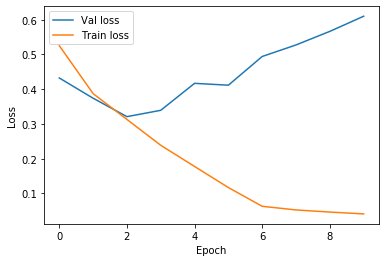

In [147]:
plt.plot([x['val_loss'] for x in history], label='Val loss')
plt.plot([x['train_loss'] for x in history], label='Train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

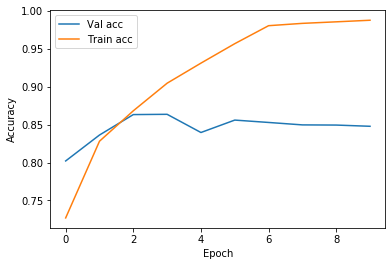

In [148]:
plt.plot([x['val_acc'] for x in history], label='Val acc')
plt.plot([x['train_acc'] for x in history], label='Train acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Model из домашки по нейросеткам Семена

[Тут](https://colab.research.google.com/drive/1fH_n-7AJ-vbPURcLNqbIe316S1qZe9ZX), потом попробовать перенести